In [2]:
%matplotlib inline
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn import tree
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
import matplotlib.pyplot as plt

In [21]:
#Put in the file path to the dataset created from extractingauthors.ipynb
df = pd.read_csv("./enron.csv")
df = df.drop(["Email Folder"], axis=1)
#We need only the top 20 authors ordered by number of emails found in either the
#sent folder or _sent_mail folder

#Add top_authors = df.value_counts(["Folder"])[:X] for the number of authors required
# Change X to 5,10,15 to test with 5, 10, 15 authors
top_authors = df.value_counts(["Folder"])[:5]
df = df.loc[df["Folder"].isin(list(top_authors.index.get_level_values(0)))].drop(["Unnamed: 0"], axis=1).reset_index(drop=True)
df = df[df["Text"]!=" "]
df = df[df["Text"]!="\n"]
df = df.dropna()

Here we are using the enron.csv file created from the noteboook "STEP2_ExtractingAuthorEmails.ipynb". This csv contains all the sent emails from 20 authors, and the extracted body of text from each email. You can change the X value too 5,10,15 to test with the corresponding number of authors. Here we are testing with 5 authors.

In [22]:
df["Folder"].value_counts()

mann-k          8167
kaminski-v      5926
dasovich-j      4805
germany-c       4571
shackleton-s    4003
Name: Folder, dtype: int64

In [23]:
def uniform_distribution(samples_per_author, df):
    df3 = pd.DataFrame(columns=["Author", "Folder", "File", "Text", "Raw Text"]) 
    for folder in df["Folder"].value_counts().index:
        df3 = df3.append(df[df["Folder"]==folder].sample(n=samples_per_author), ignore_index=True)
    return df3

In [24]:
# Change the number of samples per author here
df = uniform_distribution(4000, df)
print(df["Folder"].value_counts())
df

mann-k          4000
kaminski-v      4000
dasovich-j      4000
germany-c       4000
shackleton-s    4000
Name: Folder, dtype: int64


,Author,Folder,File,Text,Raw Text,Message ID
0,Kay,mann-k,3582.0,"Great idea. By the way, do you know if Kathle...",Message-ID: <6602280.1075846116229.JavaMail.ev...,6602280.1075846116229.
1,Kay,mann-k,3856.0,Here's what I sent to Rusty on Wednesday. It ...,Message-ID: <2374693.1075846122838.JavaMail.ev...,2374693.1075846122838.
2,Kay,mann-k,1439.0,"If it says Austin, it must be yours....\n\nKay\n",Message-ID: <31747788.1075845953235.JavaMail.e...,31747788.1075845953235.
3,Kay,mann-k,479.0,"go go go, as we say at Enron",Message-ID: <29508699.1075846039695.JavaMail.e...,29508699.1075846039695.
4,Kay,mann-k,292.0,"Suz,\n\nPlease print two originals of this CA ...",Message-ID: <25521868.1075846035256.JavaMail.e...,25521868.1075846035256.
...,...,...,...,...,...,...
19995,"Shackleton, Sara",shackleton-s,251.0,Larry Anderson with Carr has called to inquire...,Message-ID: <24932978.1075858811418.JavaMail.e...,24932978.1075858811418.
19996,Sara,shackleton-s,5736.0,Dee: Let me know if we need to discuss anythi...,Message-ID: <17913261.1075844914679.JavaMail.e...,17913261.1075844914679.
19997,Sara,shackleton-s,766.0,"Pending execution of a master agreement, Amoco...",Message-ID: <4612397.1075844535209.JavaMail.ev...,4612397.1075844535209.
19998,Sara,shackleton-s,1608.0,Sheila: Looks like Rafael never read the emai...,Message-ID: <14521752.1075844556933.JavaMail.e...,14521752.1075844556933.


The function uniform_distribution is used to sample the appropriate number of emails from the number of chosen authors. As you can initially see the number of emails per author is unbalanced with the highest being around 8000 and the lowest being around 4000. To ensure equal distribution we random sampled 4000 emails from each of the 5 authors.

In [25]:
#Here I am creating a basic text processing function, to do text cleaning
#lemmatization, stop word removal. 

def text_process(text):
    lemmatiser = WordNetLemmatizer()
    #Remove Punctuation Marks 
    nopunct=[char for char in text if char not in string.punctuation]
    nopunct=''.join(nopunct)
    #Lemmatisation 
    a=''
    i=0
    for i in range(len(nopunct.split())):
        b=lemmatiser.lemmatize(nopunct.split()[i], pos="v")
        a=a+b+' '
    #Removal of Stopwords
    words = ""
    for word in a.split():
        if word.lower():
            word = word.lower()
            if word not in stopwords.words("english"):
                words = words + word + " "
    
    return words

In [27]:
#Process all the text in each row in the df dataset
proccessed_text = df["Text"].apply(lambda row: text_process(row))
proccessed_text

0        great idea way know kathleen include law confe...
1        heres send rusty wednesday seem like option di...
2                                     say austin must kay 
3                                      go go go say enron 
4        suz please print two originals ca ca directory...
                               ...                        
19995    larry anderson carr call inquire ena financial...
19996    dee let know need discuss anything hopeful rea...
19997    pending execution master agreement amoco trans...
19998    sheila looks like rafael never read email susa...
19999    yes im available time work id rather go 11145 ...
Name: Text, Length: 20000, dtype: object

In [28]:
#Adding the processed_text as a new column on the df
df["Processed Text"] = proccessed_text

Here we are doing text preprocessing - remove all non alphanumeric characters, and removing the stop words, and adding that as a column to the dataframe

In [29]:
#Take the folder and label encode it. That will be our output label (y)
y = df["Folder"]
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

Here we are label encoding our target variable Y, which in this case is the folder name or author name of the sent email.

In [37]:
#X input variable will the processed text. Convert to numpy.

#Testing with Naive Bayes first
X = df["Processed Text"].to_numpy()
kf = KFold(n_splits=10, random_state=1, shuffle=True)
model = MultinomialNB()
training_accuracies = {k: [] for k in range(2000,24000,2000)}
testing_accuracies = {k: [] for k in range(2000,24000,2000)}
number_features = range(2000, 24000, 2000)
avg_training_accuracy = []
avg_testing_accuracy = []

i = 1
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    vectorizer = TfidfVectorizer()
    transformer = vectorizer.fit(X_train)

    X_train_transformed = transformer.transform(X_train)
    X_test_transformed = transformer.transform(X_test)
    
    for k in range(2000,24000,2000):
        print("Round {} of CV Testing".format(i))
        print("Number of Features for SelectKBest = {}".format(k))
        fs = SelectKBest(k=k)
        X_train_transformed_new = fs.fit_transform(X_train_transformed, y_train)
        X_test_transformed_new = fs.transform(X_test_transformed)

        model.fit(X_train_transformed_new, y_train)
        training_accuracy = model.score(X_train_transformed_new, y_train)
        testing_accuracy = model.score(X_test_transformed_new, y_test)
        print(training_accuracy)
        print(testing_accuracy)
        training_accuracies[k].append(training_accuracy)
        testing_accuracies[k].append(testing_accuracy)
    i = i + 1
#     training_accuracies.append(training_accuracy)
#     testing_accuracies.append(testing_accuracy)
for k in training_accuracies.keys():
    avg_training_accuracy.append(sum(training_accuracies[k])/len(training_accuracies[k]))
for k in testing_accuracies.keys():
    avg_testing_accuracy.append(sum(testing_accuracies[k])/len(testing_accuracies[k]))

#Printing out average training accuracy for each number of features selected 2000,4000,etc..
print("Average Training Accuracy")
print(avg_training_accuracy)
print("Average Testing Accuracy")
print(avg_testing_accuracy)


Round 1 of CV Testing
Number of Features for SelectKBest = 2000
0.8300555555555555
0.8295
Round 1 of CV Testing
Number of Features for SelectKBest = 4000
0.8541666666666666
0.85
Round 1 of CV Testing
Number of Features for SelectKBest = 6000
0.8658888888888889
0.858
Round 1 of CV Testing
Number of Features for SelectKBest = 8000
0.8764444444444445
0.8605
Round 1 of CV Testing
Number of Features for SelectKBest = 10000
0.8826111111111111
0.862
Round 1 of CV Testing
Number of Features for SelectKBest = 12000
0.8879444444444444
0.864
Round 1 of CV Testing
Number of Features for SelectKBest = 14000
0.8891666666666667
0.8655
Round 1 of CV Testing
Number of Features for SelectKBest = 16000
0.8904444444444445
0.867
Round 1 of CV Testing
Number of Features for SelectKBest = 18000
0.8932222222222223
0.864
Round 1 of CV Testing
Number of Features for SelectKBest = 20000
0.9000555555555556
0.871
Round 1 of CV Testing
Number of Features for SelectKBest = 22000
0.9015555555555556
0.8735
Round 2 of 

Here we are using the Processed Text and training it with MNB and checking accuracies with 10-Fold Cross Validation. Also in order to select the most relevant features from all the features produced by TFIDF Vectorizer we are using SelectKBest Features. We are searching for the optimal number of K best features by searching from 2000 to 24000 in increments of 2000. 
The average training and testing accuracy list produced contains the accuracy averaged over 10 Folds for 2000 features selected all the way upto 22000 features selected in increments of 2000

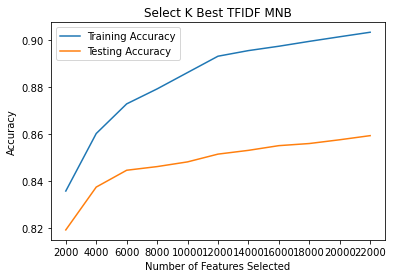

In [9]:
avg_training_accuracy_mnb = [0.8358166666666665, 0.86025, 0.8728444444444443, 0.8792055555555555, 0.8861555555555556, 0.8930944444444444, 0.8954777777777778, 0.8973333333333334, 0.8993999999999998, 0.9013611111111111, 0.903277777777778]
avg_testing_accuracy_mnb = [0.8192999999999999, 0.8375, 0.8446499999999999, 0.8462000000000002, 0.8482, 0.8514999999999999, 0.8530999999999999, 0.8551, 0.8560000000000001, 0.8575999999999999, 0.8593500000000001]

plt.plot(list(range(2000,24000,2000)), avg_training_accuracy_mnb)
plt.plot(list(range(2000,24000,2000)), avg_testing_accuracy_mnb)
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.title("Select K Best TFIDF MNB")
plt.xticks(range(2000, 24000, 2000))
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

Based on this graph we can see the optimal number of Select K best features is K=6000

In [40]:
#X input variable will the processed text. Convert to numpy.

#Testing with Random Forests
X = df["Processed Text"].to_numpy()
kf = KFold(n_splits=10, random_state=1, shuffle=True)
model = RandomForestClassifier()
training_accuracies = {k: [] for k in range(2000,24000,2000)}
testing_accuracies = {k: [] for k in range(2000,24000,2000)}
number_features = range(2000, 24000, 2000)
avg_training_accuracy = []
avg_testing_accuracy = []

i = 1
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    vectorizer = TfidfVectorizer()
    transformer = vectorizer.fit(X_train)

    X_train_transformed = transformer.transform(X_train)
    X_test_transformed = transformer.transform(X_test)

    for k in range(2000,24000,2000):
        print("Round {} of CV Testing".format(i))
        print("Number of Features for SelectKBest = {}".format(k))
        fs = SelectKBest(k=k)
        X_train_transformed_new = fs.fit_transform(X_train_transformed, y_train)
        X_test_transformed_new = fs.transform(X_test_transformed)

        model.fit(X_train_transformed_new, y_train)
        training_accuracy = model.score(X_train_transformed_new, y_train)
        testing_accuracy = model.score(X_test_transformed_new, y_test)
        print(training_accuracy)
        print(testing_accuracy)
        training_accuracies[k].append(training_accuracy)
        testing_accuracies[k].append(testing_accuracy)
    i = i + 1
#     training_accuracies.append(training_accuracy)
#     testing_accuracies.append(testing_accuracy)
for k in training_accuracies.keys():
    avg_training_accuracy.append(sum(training_accuracies[k])/len(training_accuracies[k]))
for k in testing_accuracies.keys():
    avg_testing_accuracy.append(sum(testing_accuracies[k])/len(testing_accuracies[k]))

#Printing out average training accuracy for each number of features selected 2000,4000,etc..
print("Average Training Accuracy")
print(avg_training_accuracy)
print("Average Testing Accuracy")
print(avg_testing_accuracy)

Round 1 of CV Testing
Number of Features for SelectKBest = 2000
0.9560555555555555
0.8505
Round 1 of CV Testing
Number of Features for SelectKBest = 4000
0.9627222222222223
0.8635
Round 1 of CV Testing
Number of Features for SelectKBest = 6000
0.9653888888888889
0.8575
Round 1 of CV Testing
Number of Features for SelectKBest = 8000
0.9677222222222223
0.8655
Round 1 of CV Testing
Number of Features for SelectKBest = 10000
0.9696111111111111
0.8695
Round 1 of CV Testing
Number of Features for SelectKBest = 12000
0.971
0.87
Round 1 of CV Testing
Number of Features for SelectKBest = 14000
0.9715
0.8675
Round 1 of CV Testing
Number of Features for SelectKBest = 16000
0.9716666666666667
0.8695
Round 1 of CV Testing
Number of Features for SelectKBest = 18000
0.9722222222222222
0.874
Round 1 of CV Testing
Number of Features for SelectKBest = 20000
0.9747222222222223
0.8725
Round 1 of CV Testing
Number of Features for SelectKBest = 22000
0.9753333333333334
0.8785
Round 2 of CV Testing
Number of

Here we are using the Processed Text and training it with Random Forests and checking accuracies with 10-Fold Cross Validation. Also in order to select the most relevant features from all the features produced by TFIDF Vectorizer we are using SelectKBest Features. We are searching for the optimal number of K best features by searching from 2000 to 24000 in increments of 2000. The average training and testing accuracy list produced contains the accuracy averaged over 10 Folds for 2000 features selected all the way upto 22000 features selected in increments of 2000

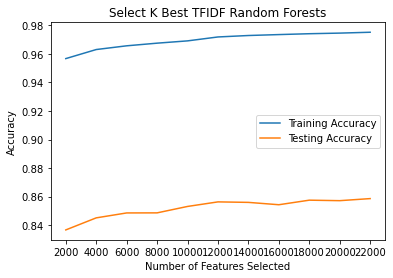

In [10]:
avg_training_accuracy_rf = [0.9567277777777777, 0.9630777777777777, 0.9656888888888888, 0.9675444444444447, 0.96915, 0.9718944444444446, 0.9729111111111113, 0.973561111111111, 0.9741666666666667, 0.9745944444444443, 0.9751999999999998]
avg_testing_accuracy_rf = [0.8366499999999999, 0.8451000000000001, 0.8485499999999998, 0.8486, 0.8531000000000001, 0.8563000000000001, 0.85595, 0.8543, 0.8574999999999999, 0.8571500000000001, 0.8586]

plt.plot(list(range(2000,24000,2000)), avg_training_accuracy_rf)
plt.plot(list(range(2000,24000,2000)), avg_testing_accuracy_rf)
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.xticks(range(2000, 24000, 2000))
plt.title("Select K Best TFIDF Random Forests")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

Based on this graph we can see the optimal number of Select K best features is K=4000

Below we have plotted the graphs for the training and testing accuracies for MNB and Random Forests
across 5, 10 and 15 authors. RandomForest Classifer gives us the best accuracy

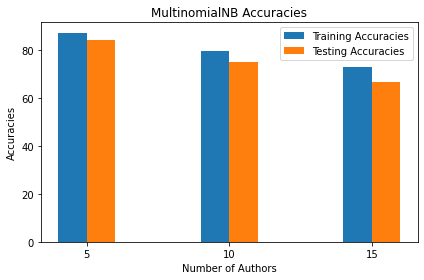

In [14]:
training_acc =[0.8728444444444443*100,79.56622222222223,73.07953216374269]
testing_acc =[0.8446499999999999*100,75.224,66.8280701754386]


labels = [5,10,15]
x = np.arange(len(labels))
length = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training Accuracies')
rects2 = ax.bar(x + width/2, testing_acc, width, label='Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('MultinomialNB Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")

ax.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

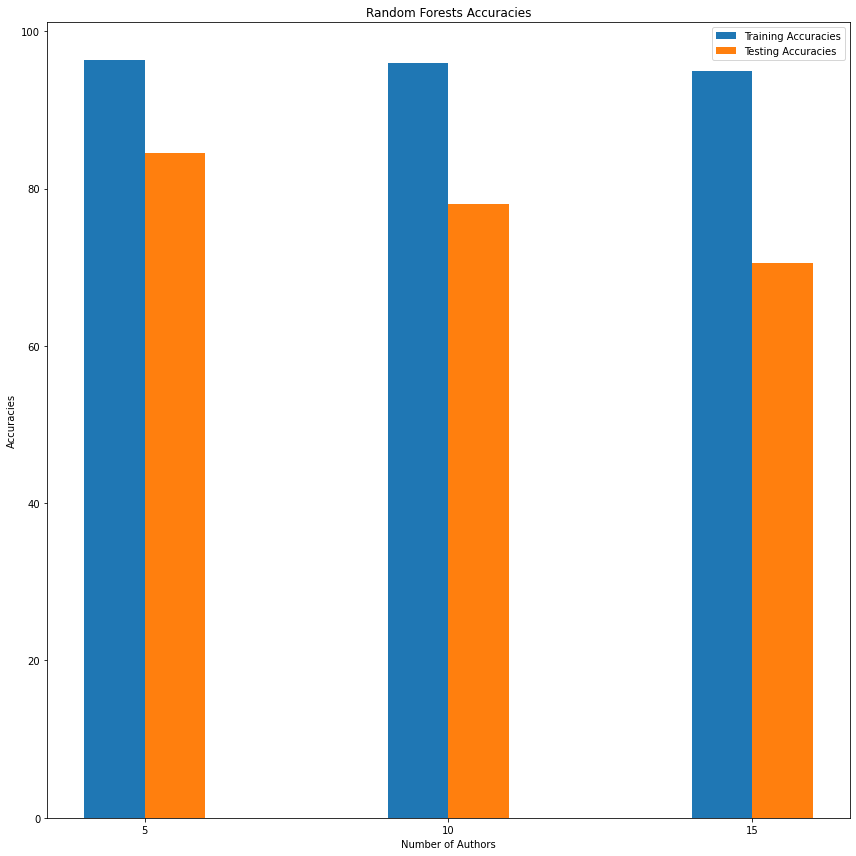

In [17]:
training_acc =[0.9630777777777777*100,95.91111111111112,95.0066276803119]
testing_acc =[0.8451000000000001*100,77.996,70.5719298245614]


labels = [5,10,15]
# ["Random Forests", "MultinomialNB"]
x = np.arange(len(labels))
length = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training Accuracies')
rects2 = ax.bar(x + width/2, testing_acc, width, label='Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Random Forests Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")

ax.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] = (12,12)
plt.show()



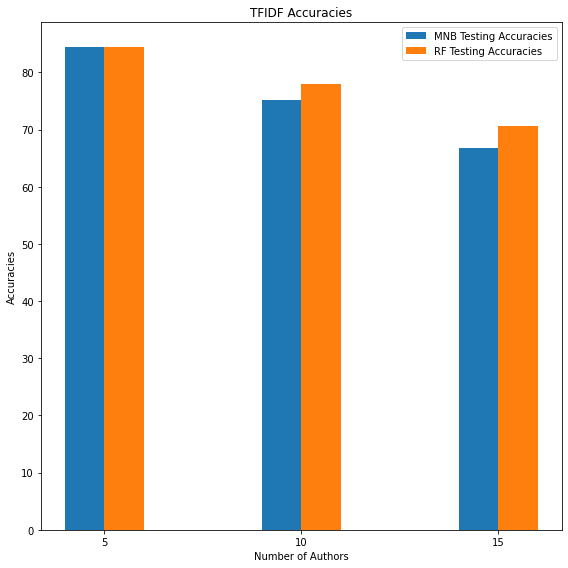

In [42]:
# rf_training_acc =[0.9630777777777777*100,95.91111111111112,95.0066276803119]
rf_testing_acc =[0.8451000000000001*100,77.996,70.5719298245614]
# mnb_training_acc =[0.8728444444444443*100,79.56622222222223,73.07953216374269]
mnb_testing_acc =[0.8446499999999999*100,75.224,66.8280701754386]


labels = [5,10,15]
# ["Random Forests", "MultinomialNB"]
x = np.arange(len(labels))
length = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
# rects1 = ax.bar(x + width, mnb_training_acc, width, label='MNB Training Accuracies')
rects2 = ax.bar(x + 2*width, mnb_testing_acc, width, label='MNB Testing Accuracies')
# rects3 = ax.bar(x + 3*width, rf_training_acc, width, label='RF Training Accuracies')
rects4 = ax.bar(x + 3*width, rf_testing_acc, width, label='RF Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('TFIDF Accuracies')
ax.set_xticks(x+(2.5*width))
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")

ax.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] = (6,6)
plt.show()



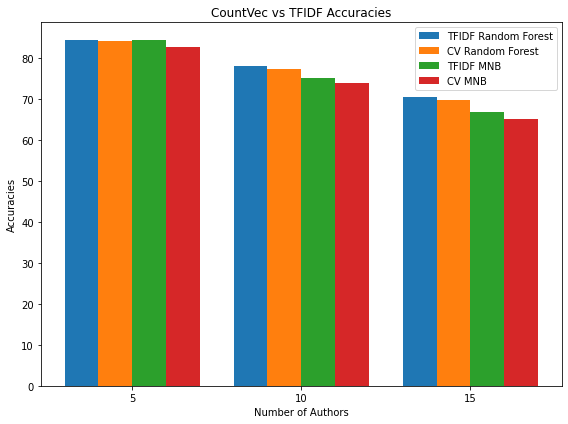

In [47]:
# rf_training_acc =[0.9630777777777777*100,95.91111111111112,95.0066276803119]
tf_rf_testing_acc =[0.8451000000000001*100,77.996,70.5719298245614]
# mnb_training_acc =[0.8728444444444443*100,79.56622222222223,73.07953216374269]
tf_mnb_testing_acc =[0.8446499999999999*100,75.224,66.8280701754386]
cv_rf_testing_acc =[0.8423*100,77.36000000000002,69.68070175438597]
cv_mnb_testing_acc =[0.8271*100,73.90800000000002,65.24210526315789]

labels = [5,10,15]
# ["Random Forests", "MultinomialNB"]
x = np.arange(len(labels))
length = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x + width, tf_rf_testing_acc, width, label='TFIDF Random Forest')
rects2 = ax.bar(x + 2*width, cv_rf_testing_acc, width, label='CV Random Forest')
rects3 = ax.bar(x + 3*width, tf_mnb_testing_acc, width, label='TFIDF MNB')
rects4 = ax.bar(x + 4*width, cv_mnb_testing_acc, width, label='CV MNB')
ax.set_ylabel('Accuracies')
ax.set_title('CountVec vs TFIDF Accuracies')
ax.set_xticks(x+(2.5*width))
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")

ax.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] = (8,6)
plt.show()
